In [1]:
!pip install wandb

In [1]:
import numpy as np
import tensorflow as tf
import keras 
import wandb
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
import os
import re

In [ ]:
with open('/root/.netrc', 'w', encoding='utf-8') as f:
    f.write('''machine api.wandb.ai
        login user
        password 3a133bd1af42ad498cbfa6e42732a9924d6c9c0b
    ''')

In [13]:
wandb.init(project="pix2pix", entity="iuh", name ='pix2pix-150')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


# defining the size of image 
SIZE = 256

image_path = '../input/cuhk-face-sketch-database-cufs/photos'
img_array = []

sketch_path = '../input/cuhk-face-sketch-database-cufs/sketches'
sketch_array = []

image_file = sorted_alphanumeric(os.listdir(image_path))
sketch_file = sorted_alphanumeric(os.listdir(sketch_path))


for i in tqdm(image_file):
    image = cv2.imread(image_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    
    #appending normal normal image    
    img_array.append(img_to_array(image))
    # Image Augmentation
    
    # horizontal flip 
    img1 = cv2.flip(image,1)
    img_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    img_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    img_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    img_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    img_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    img_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    img_array.append(img_to_array(img7))
  
    
for i in tqdm(sketch_file):
    image = cv2.imread(sketch_path + '/' + i,1)
    
    # as opencv load image in bgr format converting it to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing images 
    image = cv2.resize(image, (SIZE, SIZE))
    
    # normalizing image 
    image = image.astype('float32') / 255.0
    # appending normal sketch image
    sketch_array.append(img_to_array(image))
    
    #Image Augmentation
    # horizontal flip 
    img1 = cv2.flip(image,1)
    sketch_array.append(img_to_array(img1))
     #vertical flip 
    img2 = cv2.flip(image,-1)
    sketch_array.append(img_to_array(img2))
     #vertical flip 
    img3 = cv2.flip(image,-1)
    # horizontal flip
    img3 = cv2.flip(img3,1)
    sketch_array.append(img_to_array(img3))
    # rotate clockwise 
    img4 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    sketch_array.append(img_to_array(img4))
    # flip rotated image 
    img5 = cv2.flip(img4,1)
    sketch_array.append(img_to_array(img5))
     # rotate anti clockwise 
    img6 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    sketch_array.append(img_to_array(img6))
    # flip rotated image 
    img7 = cv2.flip(img6,1)
    sketch_array.append(img_to_array(img7))

100%|██████████| 188/188 [00:01<00:00, 116.36it/s]


In [15]:
# defining function to plot images pair
def plot_images(image, sketches):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Sketch', color = 'green', fontsize = 20)
    plt.imshow(sketches)
    plt.subplot(1,2,2)
    plt.title('Image', color = 'black', fontsize = 20)
    plt.imshow(image)
   
    plt.show()

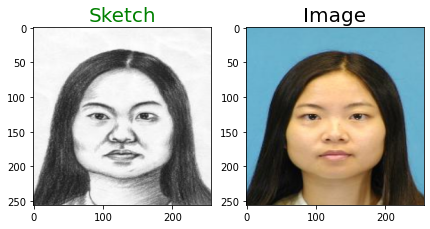

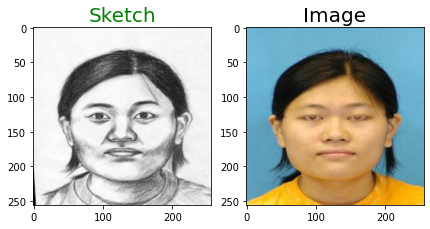

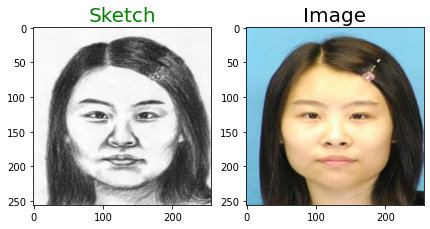

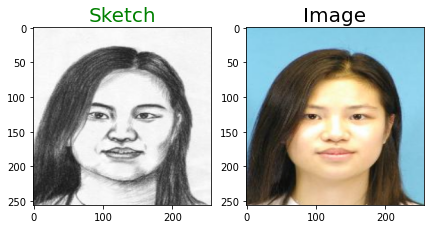

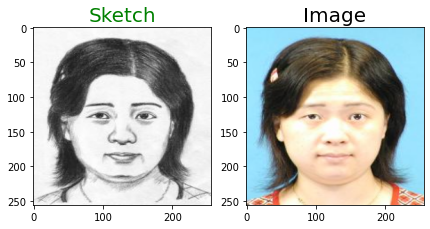

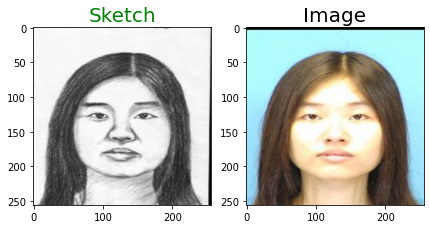

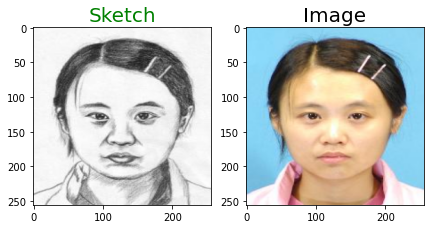

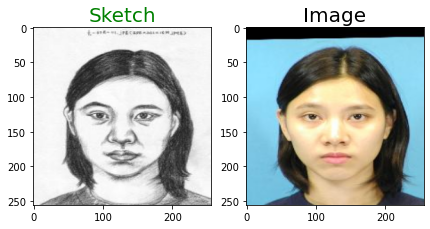

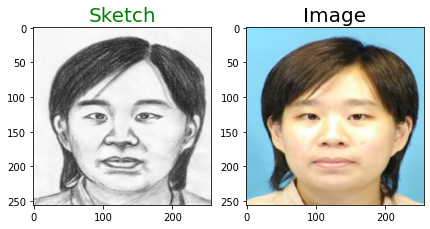

In [16]:
ls = [i for i in range(0,65,8)]
for i in ls:
    plot_images(img_array[i],sketch_array[i])

In [17]:
train_sketch_image = sketch_array[:1200]
train_image = img_array[:1200]
test_sketch_image = sketch_array[1200:]
test_image = img_array[1200:]
# reshaping
train_sketch_image = np.reshape(train_sketch_image,(len(train_sketch_image),SIZE,SIZE,3))
train_image = np.reshape(train_image, (len(train_image),SIZE,SIZE,3))
print('Train color image shape:',train_image.shape)
test_sketch_image = np.reshape(test_sketch_image,(len(test_sketch_image),SIZE,SIZE,3))
test_image = np.reshape(test_image, (len(test_image),SIZE,SIZE,3))
print('Test color image shape',test_image.shape)

Train color image shape: (1200, 256, 256, 3)
Test color image shape (304, 256, 256, 3)


In [18]:
def downsample(filters, size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(keras.layers.Conv2D(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_batch_normalization:
        downsample.add(keras.layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [19]:
def upsample(filters, size, apply_dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(keras.layers.Conv2DTranspose(filters = filters, kernel_size = size, strides = 2, use_bias = False, kernel_initializer = 'he_normal'))
    if apply_dropout:
        upsample.add(tf.keras.layers.Dropout(0.1))
    upsample.add(tf.keras.layers.LeakyReLU()) 
    return upsample

In [20]:
def model():
    encoder_input = keras.Input(shape = (SIZE, SIZE, 3))
    x = downsample(16, 4, False)(encoder_input)
    x = downsample(32,4)(x)
    x = downsample(64,4,False)(x)
    x = downsample(128,4)(x)
    x = downsample(256,4)(x)
   
    encoder_output = downsample(512,4)(x)
    
    decoder_input = upsample(512,4,True)(encoder_output)
    x = upsample(256,4,False)(decoder_input)
    x = upsample(128,4, True)(x)
    x = upsample(64,4)(x)
    x = upsample(32,4)(x)
    x = upsample(16,4)(x)
    x = tf.keras.layers.Conv2DTranspose(8,(2,2),strides = (1,1), padding = 'valid')(x)
    decoder_output = tf.keras.layers.Conv2DTranspose(3,(2,2),strides = (1,1), padding = 'valid')(x)
    
  
    return tf.keras.Model(encoder_input, decoder_output)
def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val = 1)

In [21]:
# to get summary of model
model = model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential_12 (Sequential)   (None, 127, 127, 16)      768       
_________________________________________________________________
sequential_13 (Sequential)   (None, 62, 62, 32)        8320      
_________________________________________________________________
sequential_14 (Sequential)   (None, 30, 30, 64)        32768     
_________________________________________________________________
sequential_15 (Sequential)   (None, 14, 14, 128)       131584    
_________________________________________________________________
sequential_16 (Sequential)   (None, 6, 6, 256)         525312    
_________________________________________________________________
sequential_17 (Sequential)   (None, 2, 2, 512)         2099

In [22]:
from wandb.keras import WandbCallback

In [23]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc',ssim])

# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)
model.fit(train_sketch_image,train_image, epochs = 150, verbose = 1,validation_data=(test_sketch_image, test_image),
          callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-12-15 08:15:40.678348: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 943718400 exceeds 10% of free system memory.
2022-12-15 08:15:41.708649: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 943718400 exceeds 10% of free system memory.
2022-12-15 08:15:42.780041: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 943718400 exceeds 10% of free system memory.
2022-12-15 08:15:43.521824: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 943718400 exceeds 10% of free system memory.
2022-12-15 08:15:44.801646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA 

Epoch 1/150


2022-12-15 08:15:48.964023: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


38/38 [==============================] - 15s 163ms/step - loss: 0.2655 - acc: 0.2861 - ssim: 0.1037 - val_loss: 4.3475 - val_acc: 0.2747 - val_ssim: 0.0095
Epoch 2/150
38/38 [==============================] - 4s 118ms/step - loss: 0.1449 - acc: 0.6960 - ssim: 0.2490 - val_loss: 1.3639 - val_acc: 0.2859 - val_ssim: 0.0459
Epoch 3/150
38/38 [==============================] - 4s 115ms/step - loss: 0.1295 - acc: 0.7904 - ssim: 0.3235 - val_loss: 0.3212 - val_acc: 0.4804 - val_ssim: 0.2422
Epoch 4/150
38/38 [==============================] - 4s 115ms/step - loss: 0.1202 - acc: 0.8191 - ssim: 0.3772 - val_loss: 0.1684 - val_acc: 0.7738 - val_ssim: 0.4413
Epoch 5/150
38/38 [==============================] - 5s 119ms/step - loss: 0.1121 - acc: 0.8347 - ssim: 0.4127 - val_loss: 0.1397 - val_acc: 0.8597 - val_ssim: 0.5159
Epoch 6/150
38/38 [==============================] - 4s 114ms/step - loss: 0.1092 - acc: 0.8429 - ssim: 0.4477 - val_loss: 0.1089 - val_acc: 0.8561 - val_ssim: 0.4781
Epoch 7/1

In [24]:
prediction_on_test_data = model.evaluate(test_sketch_image, test_image)
print("Loss: ", prediction_on_test_data[0])
print("Accuracy: ", np.round(prediction_on_test_data[1] * 100,1))

10/10 [==============================] - 1s 61ms/step - loss: 0.0940 - acc: 0.8924 - ssim: 0.7135
Loss:  0.09404181689023972
Accuracy:  89.2


In [25]:
def show_images(sketch, image, predicted):
    plt.figure(figsize = (12,12))
    plt.subplot(1,3,1)
    plt.title("Sketch",fontsize = 15, color = 'Lime')
    plt.imshow(sketch)
    plt.subplot(1,3,2)
    plt.title("Image",fontsize = 15, color = 'Blue')
    plt.imshow(image)
    plt.subplot(1,3,3)
    plt.title("Predicted",fontsize = 15, color = 'gold')
    plt.imshow(predicted)

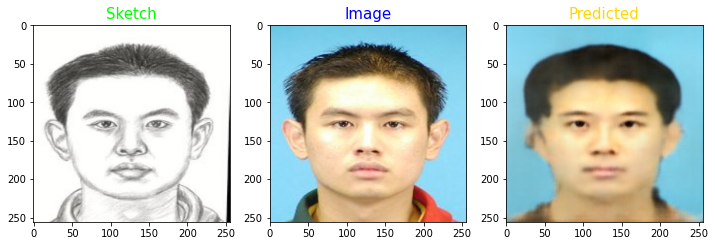

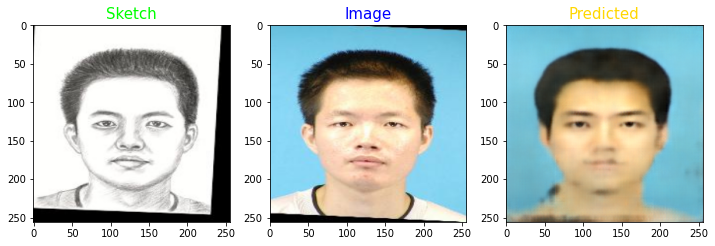

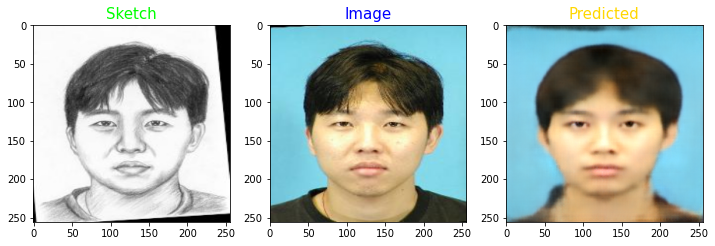

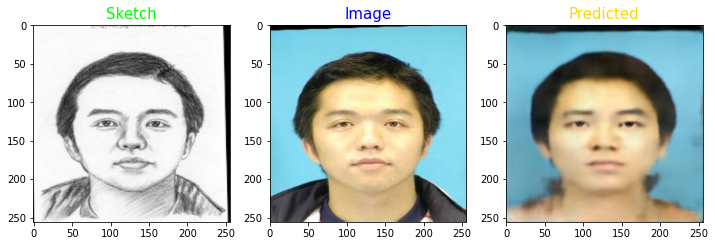

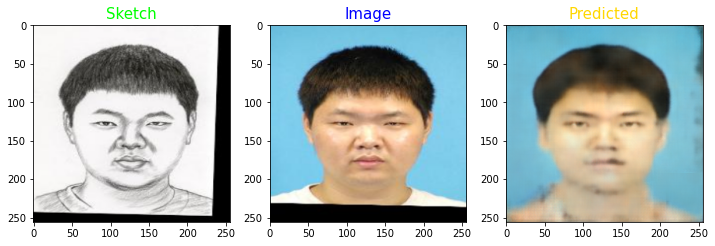

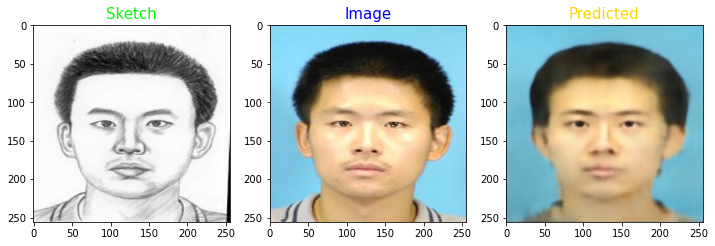

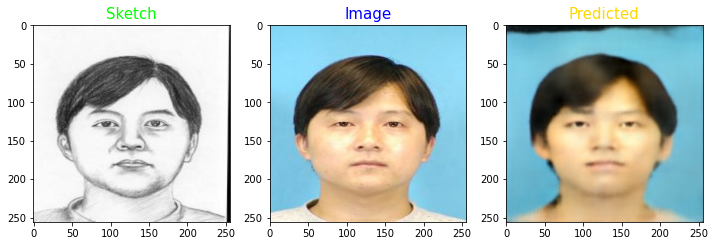

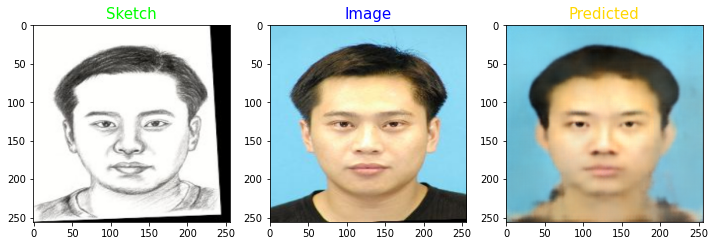

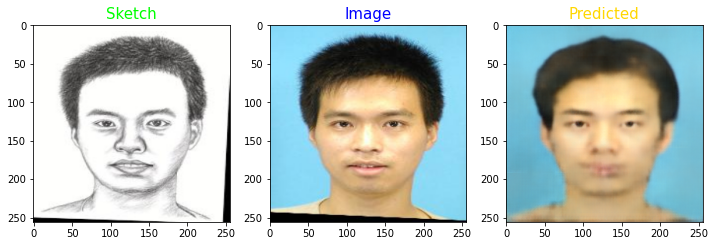

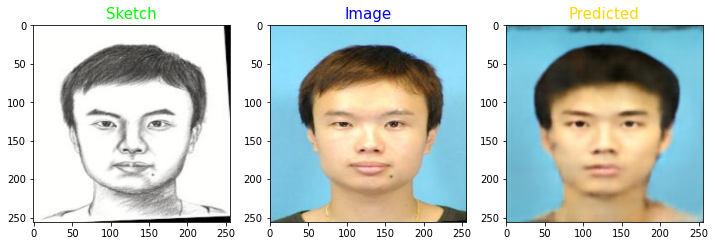

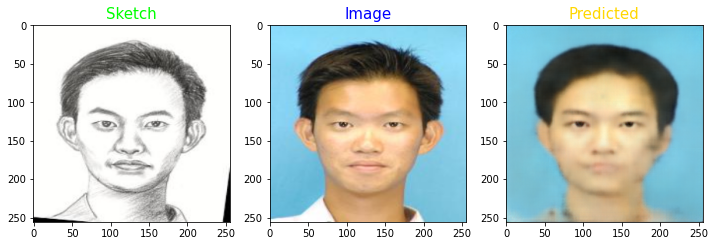

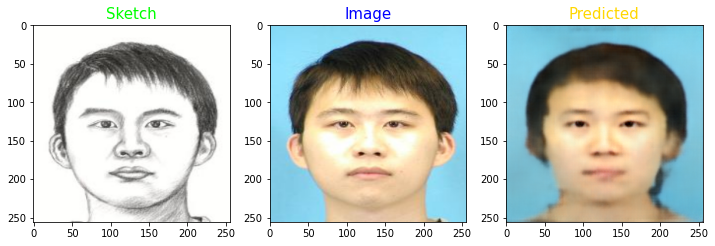

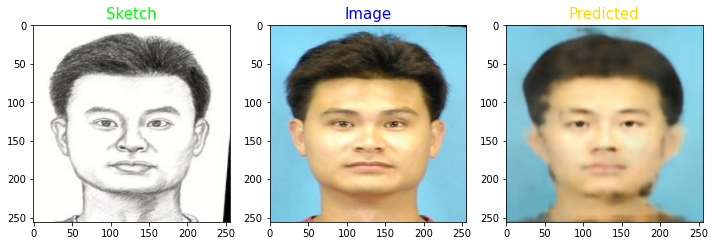

In [26]:
ls = [i for i in range(0,100,8)]
for i in ls:
    predicted =np.clip(model.predict(test_sketch_image[i].reshape(1,SIZE,SIZE,3)),0.0,1.0).reshape(SIZE,SIZE,3)
    show_images(test_sketch_image[i],test_image[i],predicted)

In [ ]:
# model.save('pix2pix.h5')

In [ ]:
# model.save_weights('pix2pix_weights.h5')

In [27]:
# os.listdir(checkpoint_dir)